In [1]:
_# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
_
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.precision', 2)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

### Load Python Packages

In [2]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.base import clone
from sklearn import set_config
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy.stats import randint, mode
from scipy.optimize import minimize

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

#feature engineering
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV

#algorithms
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, make_scorer, RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, matthews_corrcoef, cohen_kappa_score

# Optuna and visualization tools
import optuna
USE_OPTUNA = False
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from matplotlib.colors import LinearSegmentedColormap

random_state = 42

SEED = 42
n_splits = 5

### Lets look into data

#### Check for missing values

In [3]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample_sub = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [4]:
train_df.isna().sum()

id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 82, dtype: int64

In [5]:
test_df.isna().sum()

id                                         0
Basic_Demos-Enroll_Season                  0
Basic_Demos-Age                            0
Basic_Demos-Sex                            0
CGAS-Season                               10
CGAS-CGAS_Score                           12
Physical-Season                            6
Physical-BMI                               7
Physical-Height                            7
Physical-Weight                            7
Physical-Waist_Circumference              15
Physical-Diastolic_BP                      9
Physical-HeartRate                         8
Physical-Systolic_BP                       9
Fitness_Endurance-Season                  16
Fitness_Endurance-Max_Stage               17
Fitness_Endurance-Time_Mins               17
Fitness_Endurance-Time_Sec                17
FGC-Season                                 3
FGC-FGC_CU                                 7
FGC-FGC_CU_Zone                            7
FGC-FGC_GSND                              15
FGC-FGC_GS

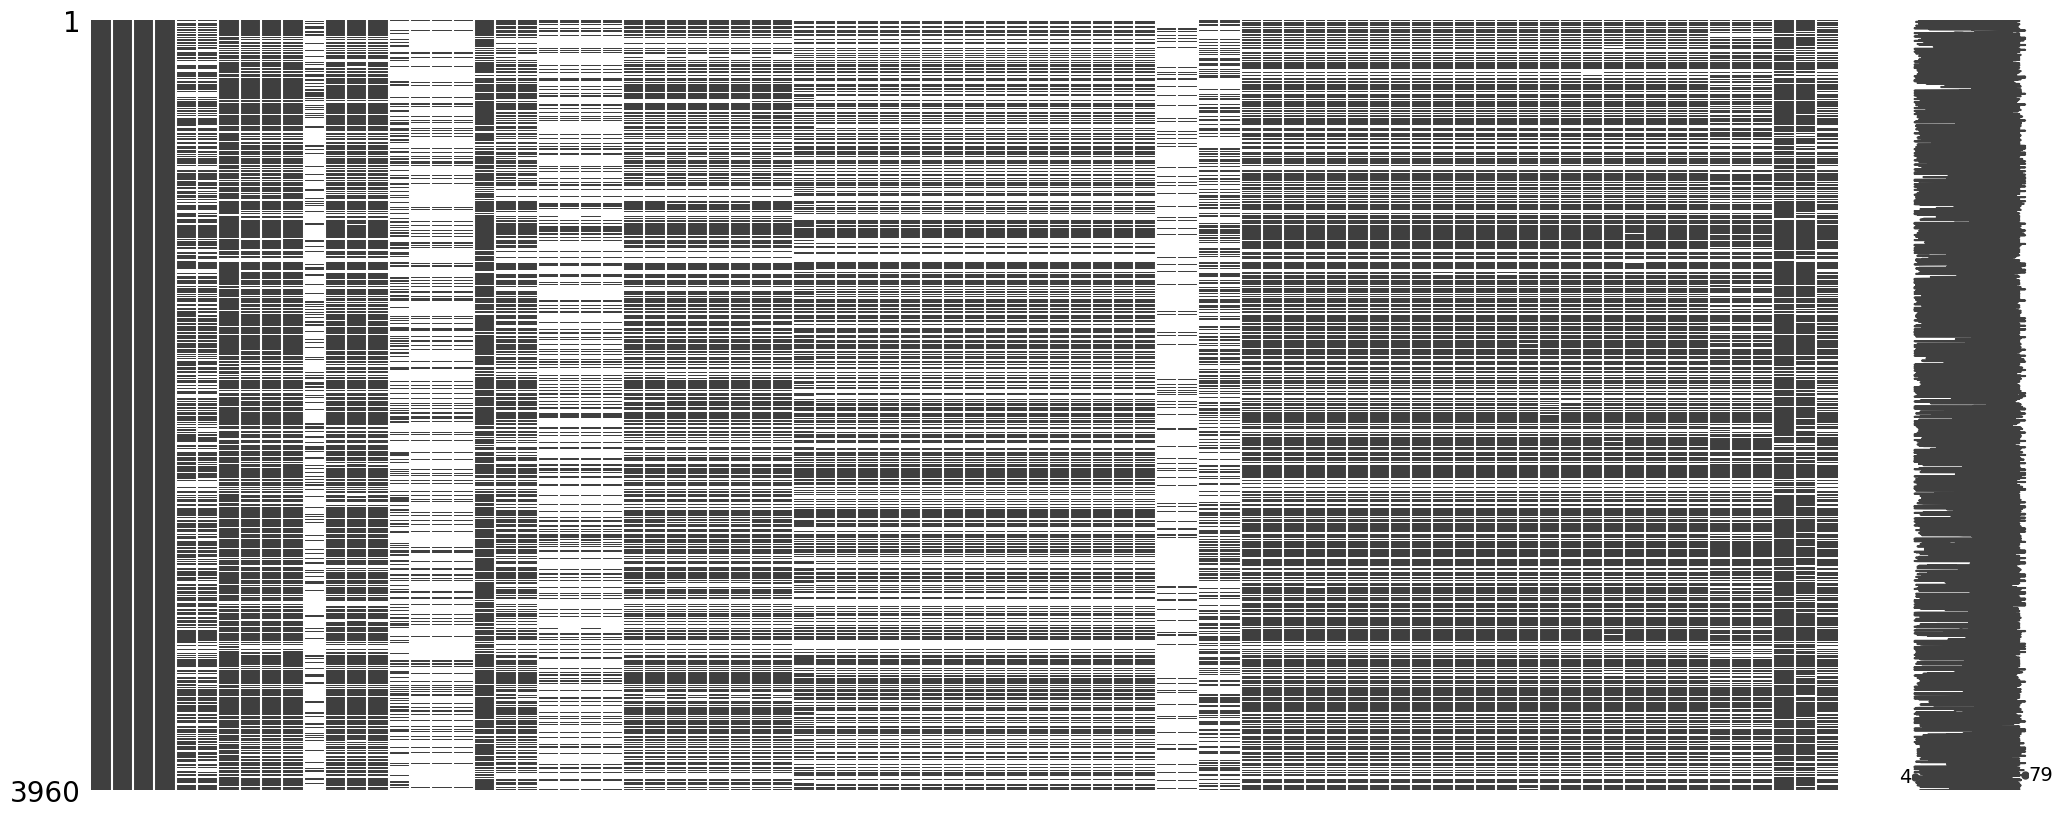

In [6]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

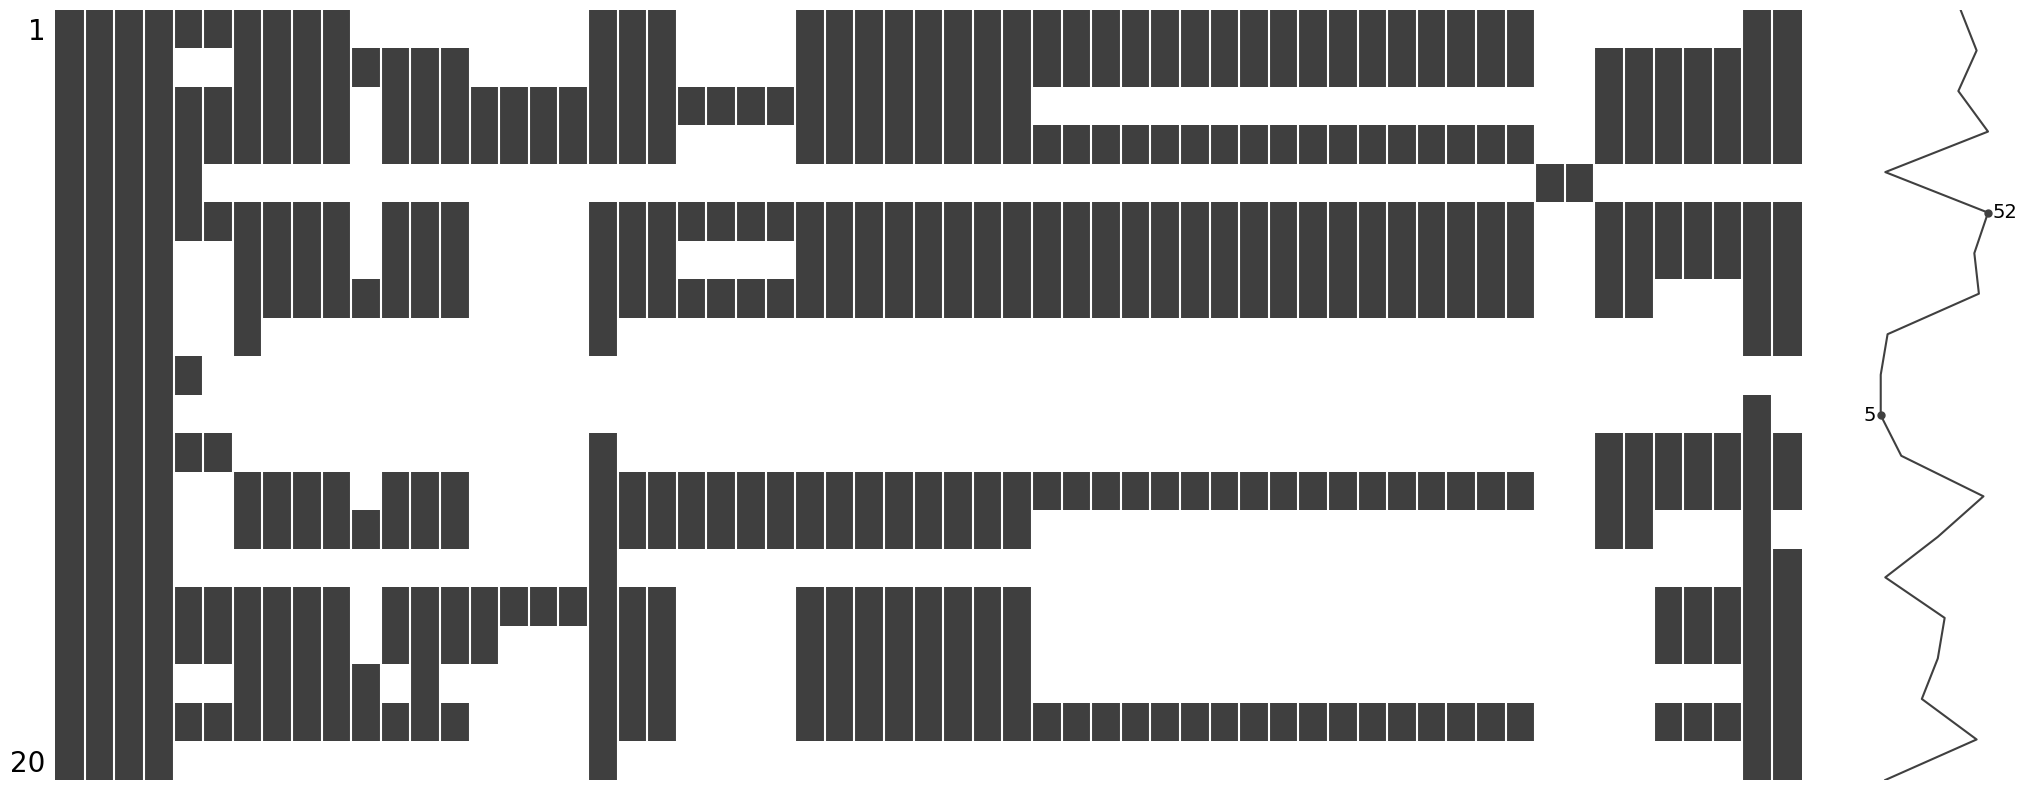

In [7]:
%matplotlib inline
msno.matrix(test_df)
plt.show()

In [8]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df)*100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
PAQ_A-PAQ_A_Total,3485,88.005051
PAQ_A-Season,3485,88.005051
Fitness_Endurance-Time_Sec,3220,81.313131
Fitness_Endurance-Time_Mins,3220,81.313131
Fitness_Endurance-Max_Stage,3217,81.237374
Physical-Waist_Circumference,3062,77.323232
FGC-FGC_GSND_Zone,2898,73.181818
FGC-FGC_GSD_Zone,2897,73.156566
FGC-FGC_GSD,2886,72.878788
FGC-FGC_GSND,2886,72.878788


In [9]:
missing = pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(test_df)*100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
PAQ_A-PAQ_A_Total,19,95.000000
PAQ_A-Season,19,95.000000
Fitness_Endurance-Time_Sec,17,85.000000
Fitness_Endurance-Time_Mins,17,85.000000
Fitness_Endurance-Max_Stage,17,85.000000
Fitness_Endurance-Season,16,80.000000
FGC-FGC_GSND,15,75.000000
FGC-FGC_GSD,15,75.000000
FGC-FGC_GSD_Zone,15,75.000000
Physical-Waist_Circumference,15,75.000000


### Pre-processing

In [10]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

In [11]:
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [12]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


In [13]:
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

In [14]:
train_combo = pd.merge(train_df, train_ts, how="left", on='id')
test_combo = pd.merge(test_df, test_ts, how="left", on='id')

In [15]:
train_combo = train_combo.drop('id', axis=1)
test_combo = test_combo.drop('id', axis=1)

### Descriptive statistics

In [16]:
#numerical feature descriptive statistics

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Basic_Demos-Age,3960.0,10.43,3.57,5.0,8.00,10.00,13.00,22.00
Basic_Demos-Sex,3960.0,0.37,0.48,0.0,0.00,0.00,1.00,1.00
CGAS-CGAS_Score,2421.0,65.45,22.34,25.0,59.00,65.00,75.00,999.00
Physical-BMI,3022.0,19.33,5.11,0.0,15.87,17.94,21.57,59.13
Physical-Height,3027.0,55.95,7.47,33.0,50.00,55.00,62.00,78.50
...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,2736.0,27.90,20.34,0.0,12.00,26.00,41.00,93.00
SDS-SDS_Total_Raw,2609.0,41.09,10.43,17.0,33.00,39.00,46.00,96.00
SDS-SDS_Total_T,2606.0,57.76,13.20,38.0,47.00,55.00,64.00,100.00
PreInt_EduHx-computerinternet_hoursday,3301.0,1.06,1.09,0.0,0.00,1.00,2.00,3.00


### Grouping features for preprocessing purposes

In [17]:
train_df.nunique().sort_values()

FGC-FGC_CU_Zone        2
Basic_Demos-Sex        2
FGC-FGC_TL_Zone        2
FGC-FGC_SRR_Zone       2
FGC-FGC_SRL_Zone       2
                    ... 
BIA-BIA_BMC         1986
BIA-BIA_Fat         1988
BIA-BIA_TBW         1989
Physical-BMI        2658
id                  3960
Length: 82, dtype: int64

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

### Feature Types

In [19]:
cat_fea = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_fea = train_df.select_dtypes(exclude=['object', 'category']).columns.tolist()

for feature in ['sii']:
    if feature in num_fea:
        num_fea.remove(feature)

# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': num_fea})
df_categorical = pd.DataFrame({'Categorical Variables': cat_fea})

print(df_numerical)
print(df_categorical)

                       Numerical Variables
0                          Basic_Demos-Age
1                          Basic_Demos-Sex
2                          CGAS-CGAS_Score
3                             Physical-BMI
4                          Physical-Height
..                                     ...
64                          PCIAT-PCIAT_20
65                       PCIAT-PCIAT_Total
66                       SDS-SDS_Total_Raw
67                         SDS-SDS_Total_T
68  PreInt_EduHx-computerinternet_hoursday

[69 rows x 1 columns]
        Categorical Variables
0                          id
1   Basic_Demos-Enroll_Season
2                 CGAS-Season
3             Physical-Season
4    Fitness_Endurance-Season
5                  FGC-Season
6                  BIA-Season
7                PAQ_A-Season
8                PAQ_C-Season
9                PCIAT-Season
10                 SDS-Season
11        PreInt_EduHx-Season


### Exploratory Data Analysis

In [20]:
def fill_missing_values(df):
    categorical_cols = df.select_dtypes(include=['category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Fill categorical columns, 
    for col in categorical_cols:
        # Add 'Missing' as a category if it is not already present
        if 'Missing' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories('Missing')
        df[col].fillna('Missing', inplace=True)
    
    # Fill numerical columns
    for col in numerical_cols:
        df[col].fillna(df[col].mean(), inplace=True)  # You can use median or other strategies as needed


In [21]:
fill_missing_values(train_combo)
fill_missing_values(test_combo)

In [22]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols
train_combo = train_combo[featuresCols]
train_combo = train_combo.dropna(subset='sii')

In [23]:
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

# Update categorical columns
def update(df):
    for c in cat_c:
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

In [24]:
train_combo = update(train_combo)
test_combo = update(test_combo)

In [25]:
# Create mapping function
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

In [26]:
# Encode categorical features
for col in cat_c:
    mapping = create_mapping(col, train_combo)
    mappingTe = create_mapping(col, test_combo)
    
    train_combo[col] = train_combo[col].replace(mapping).astype(int)
    test_combo[col] = test_combo[col].replace(mappingTe).astype(int)

In [27]:
# Convert target variable
train_combo['sii'] = train_combo['sii'].round().astype(int)

In [28]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [29]:
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

In [30]:
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [31]:
# TrainML function
def TrainML(model_class, test_data):
    X = train_combo.drop(['sii'], axis=1)
    y = train_combo['sii']
    
    # Ensure test_data has the same columns as train
    test_data = test_data[X.columns]
    
    # Using KFold for continuous target
    SKF = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[val_idx] = y_val_pred
        oof_rounded[val_idx] = np.round(y_val_pred).astype(int)

        train_kappa = quadratic_weighted_kappa(y_train, np.round(y_train_pred).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, oof_rounded[val_idx])

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)

        print(f"Fold {fold + 1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample_sub['id'],  # Ensure 'sample' DataFrame is defined with 'id'
        'sii': tpTuned
    })

    return submission

In [32]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01
}

In [33]:
# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': SEED
}

In [34]:
CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 8
}

In [35]:
# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

In [36]:
# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

In [37]:
# Train the ensemble model
Submission = TrainML(voting_model, test_combo)

Training Folds:  20%|██        | 1/5 [00:12<00:51, 12.79s/it]

Fold 1 - Train QWK: 0.7332, Validation QWK: 0.4250


Training Folds:  40%|████      | 2/5 [00:24<00:36, 12.11s/it]

Fold 2 - Train QWK: 0.7461, Validation QWK: 0.3801


Training Folds:  60%|██████    | 3/5 [00:35<00:23, 11.80s/it]

Fold 3 - Train QWK: 0.7397, Validation QWK: 0.4736


Training Folds:  80%|████████  | 4/5 [00:47<00:11, 11.92s/it]

Fold 4 - Train QWK: 0.7378, Validation QWK: 0.4543


Training Folds: 100%|██████████| 5/5 [00:59<00:00, 11.97s/it]

Fold 5 - Train QWK: 0.7345, Validation QWK: 0.4496
Mean Train QWK --> 0.7382
Mean Validation QWK ---> 0.4365
----> || Optimized QWK SCORE :: 0.484


In [38]:
# Save submission
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
0    13
1     7
Name: count, dtype: int64
